### Learning prior iteratively

In [1]:
# setup the environment
import nengo
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
% matplotlib inline

import matplotlib as mpl
label_size = 18
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size

import seaborn as sns
sns.set_context("talk")

In [2]:
def IA(d, n_neurons, dt, share_thresholding_intercepts=False):
    bar_beta = 2.  # should be >= 1 + max_input * tau2 / tau1
    tau_model1 = 0.1
    tau_model2 = 0.1
    tau_actual = 0.1

    # dynamics put into continuous LTI form:
    #   dot{x1} = A1x1 + A2x2 + Bu
    # where x1 is the state variable for layer 1 and
    #       x2 is the state variable for layer 2
    # note that from the perspective of Principle 3, A2x2 is treated
    # as an "input" similar to u
    I = np.eye(d)
    inhibit = 1 - I
    B = 1. / tau_model1  # input -> layer 1
    A1 = 0  # (integrator) layer1 -> layer1
    A2 = (I - bar_beta * inhibit) / tau_model2  # layer 2 -> layer 1

    n_neurons_threshold = 50
    n_neurons_x = n_neurons - n_neurons_threshold
    assert n_neurons_x > 0
    threshold = 0.8

    with nengo.Network(label="IA") as net:
        net.input = nengo.Node(size_in=d)
        x = nengo.networks.EnsembleArray(
            n_neurons_x, d,
            eval_points=nengo.dists.Uniform(0., 1.),
            intercepts=nengo.dists.Uniform(0., 1.),
            encoders=nengo.dists.Choice([[1.]]), label="Layer 1")
        net.x = x
        nengo.Connection(x.output, x.input, transform=tau_actual * A1 + I,
                         synapse=tau_actual)

        nengo.Connection(
            net.input, x.input,
            transform=tau_actual * B,
            synapse=tau_actual)

        with nengo.presets.ThresholdingEnsembles(0.):
            thresholding = nengo.networks.EnsembleArray(
                n_neurons_threshold, d, label="Layer 2")
            if share_thresholding_intercepts:
                for e in thresholding.ensembles:
                    e.intercepts = nengo.dists.Exponential(
                        0.15, 0., 1.).sample(n_neurons_threshold)
            net.output = thresholding.add_output('heaviside', lambda x: x > 0.)

        bias = nengo.Node(1., label="Bias")

        nengo.Connection(x.output, thresholding.input, synapse=0.005)
        nengo.Connection(
            bias, thresholding.input, transform=-threshold * np.ones((d, 1)))
        nengo.Connection(
            thresholding.heaviside, x.input,
            transform=tau_actual * A2, synapse=tau_actual)

    return net

In [3]:
# assuming that maximum possible age is 120 yrs
max_age = 120

# our function domain is thetas (i.e., age from 1 to 120)
# Remember thetas is same as Z in our plate notation (shown later)
# We are also assuming discrete values for age, because people 
# usually report integers for age when asked to predict.
thetas = np.linspace(start=1, stop=max_age, num=max_age)

# compute likelihood 
def likelihood(x):
    x = int(x)
    like = np.asarray([1/p for p in thetas])
    like[0:x-1] = [0]*np.asarray(x-1)
    return like

# computer prior
def skew_gauss(skew, loc, scale):
    prior = [(st.skewnorm.pdf(p, a=skew, loc=loc, scale=scale)) for p in thetas] 
    prior = prior/sum(prior)
    return prior

# computer posterior
def posterior(x, skew, loc, scale):
    post = likelihood(x=x)*skew_gauss(skew=skew, loc=loc, scale=scale)
    post = post/sum(post)
    return post

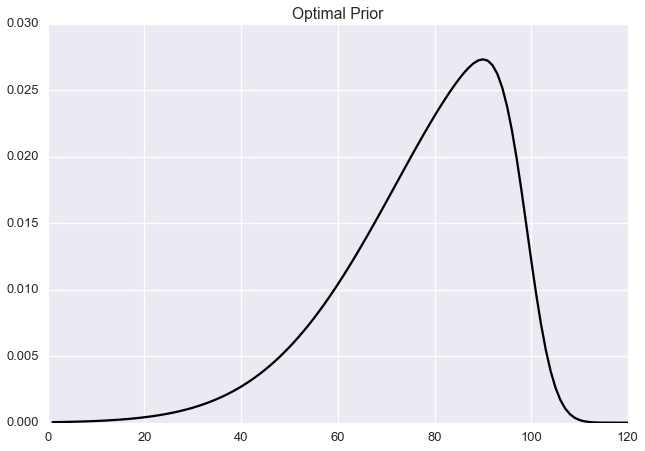

In [4]:
# Prior which is the actual solution and
# is used to generate the observed data 

# prior parameters
#skew = -4    # fixed parameter
#loc = 95     # to be estimated
#scale = 26   # fixed parameter

skew = -6    # fixed parameter
loc = 99    # to be estimated
scale = 27   # fixed parameter


prior = skew_gauss(skew, loc, scale)
plt.figure()
plt.title("Optimal Prior")
plt.plot(thetas, prior, 'k')


mean = st.skewnorm.mean(skew, loc, scale)
std_dev = st.skewnorm.std(skew, loc, scale)
#print "Mean: ", mean
#print "Std. deviation: ", std_dev

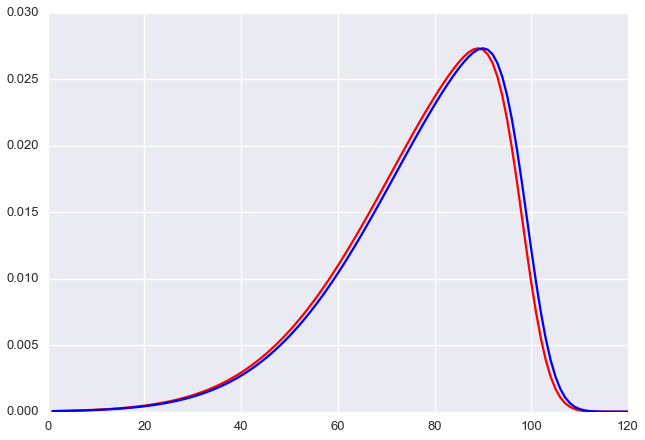

In [5]:
# Showing that the difference between priors with 
# loc = 95 and 96 is not too much and hence the fractional 
# values between any two integer values of loc can be ignored
# to limit the search space and simplify the problem.
plt.figure()
prior = skew_gauss(skew, 98, 27)
plt.plot(thetas, prior, 'r')
prior = skew_gauss(skew, 99, 27)
plt.plot(thetas, prior, 'b')

Mean:  -0.249769032776
Std. deviation:  16.6567498647
Mean:  120.750230967
Std. deviation:  16.6567498647


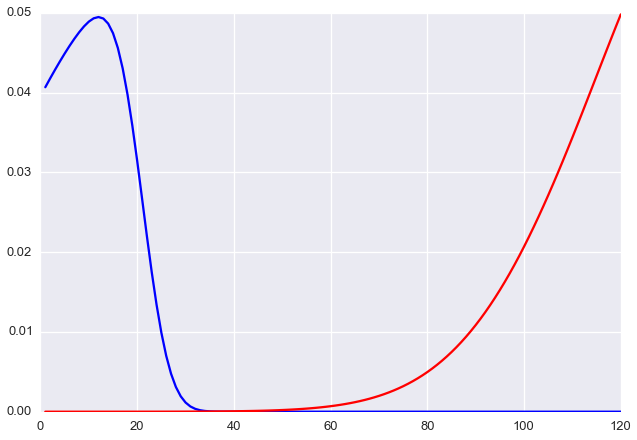

In [6]:
# The Prior is conditioned on three parameters, however
# we assume that two of the parameters are fixed and estimate
# only one parameter 'loc'. Thus the hyperparameter alpha to  
# be is estimated is 'loc' in this case.

# Check the range of values we should be searching over.
# We know that the mean age should be between 0 to 120 since 
# we are assuming max age is 120. Hence, we should search over
# the range of values of 'loc' that give mean between 0 to 120.

# lower bound
loc_r = 21 

prior = skew_gauss(skew, loc_r, scale)
plt.figure()
plt.plot(thetas, prior, 'b')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# upper bound
loc_r = 142 

prior = skew_gauss(skew, loc_r, scale)
plt.plot(thetas, prior, 'r')

mean = st.skewnorm.mean(skew, loc_r, scale)
std_dev = st.skewnorm.std(skew, loc_r, scale)
print "Mean: ", mean
print "Std. deviation: ", std_dev

# Thus the search range for 'loc' is 20 to 141 since priors
# beyond these values wouldn't make sense for this problem
# The hypothesis is that people are able to constrain their
# search space based on the knowledge of min and max ages
# they observe in the world around them.

# Thus loc has discrete values from 20 - 141. 
# Remember alpha = loc 
upper = 142 
lower = 21
alpha = np.arange(lower, upper+1, 1)   # possible values of alpha
#M = upper-lower+1  # number of discrete possibilities of alpha

The two stage hierarchical bayes model is summarised in the <a href="https://en.wikipedia.org/wiki/Plate_notation">Plate notation</a> as follows:
![](http://i.imgur.com/gmLKIjJ.png)

The data is generated in the forward direction ($\alpha \longrightarrow Z \longrightarrow X$). Then only $X$ is accessible to the model, along with the "knowledge" of how this was generated. The actual parameters for $Z$ and $\alpha$ are hidden from the model. The task is then to infer the most likely $Z$ and $\alpha$ given the observed sample $X$.

In [246]:
# These two functions are used to generate the sample X. 
skew_original = -6    # fixed parameter
loc_original = 99    # to be estimated
scale_original = 27   # fixed parameter

# Function to sample discrete random values from a skewed gaussian distribution
def randn_skew(n_samples, skew=0.0, loc=0.0, scale=1.0):
    probs = skew_gauss(skew, loc, scale)
    samples = np.random.choice(thetas, size=n_samples, replace=True, p=probs)   
    samples = list(samples)  #convert ndarray to a python list
    return samples

# Function to draw samples X for the given number of trials
# prior gives the total lifespan, but x (samples) are current ages observed
# so x should be <= total lifespan
def draw(n_trials, n_samples):
    x_vector = []
    for i in np.arange(n_trials):
        # generating Z from alpha
        z_vector = randn_skew(n_samples=n_samples, skew=skew_original, loc=loc_original, scale=scale_original)  
        x_vector.append(np.asarray([np.random.randint(low=1, high=th+1) for th in z_vector]))   # X from Z
    return x_vector

20
28


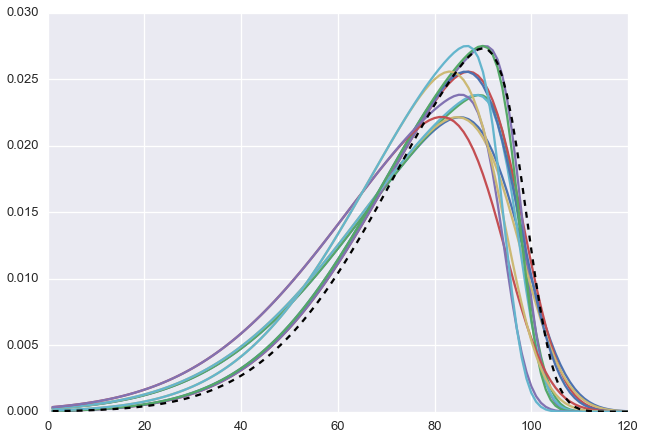

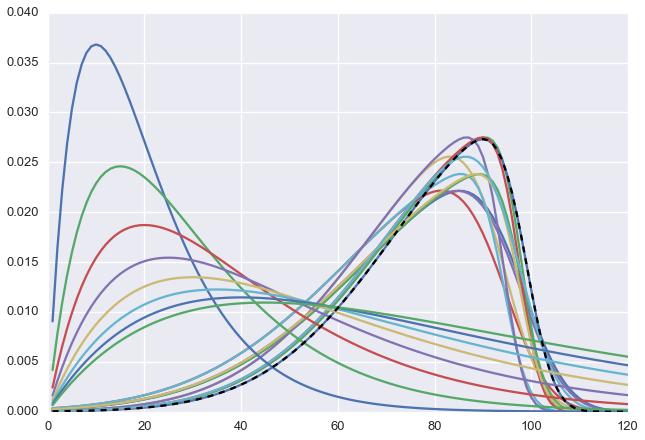

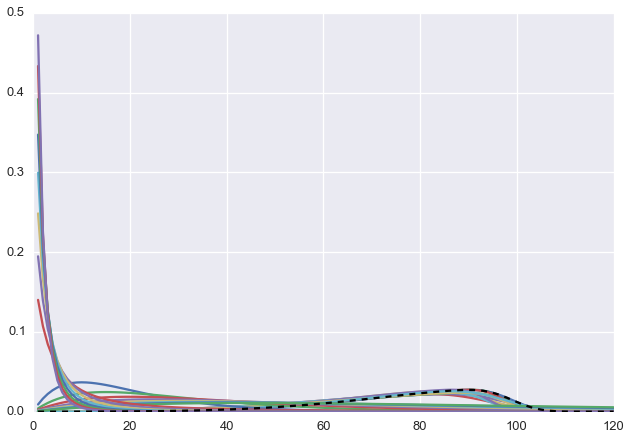

In [14]:
# Start here for basal ganglia
# rmse pretty low 0.0007 upto 0.04 with 15, 15, 3 samples
# rmse similar with 10, 10, 3 samples as well. 
#alpha = np.random.uniform(89, 109, 10)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 10)    #scale 
#alpha3 = np.random.uniform(-8, -4, 1)     #skew

#alpha = np.random.uniform(94, 104, 5)    #loc or shift
#alpha2 = np.random.uniform(22, 32, 5)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

#alpha = np.random.uniform(79, 109, 4)    #loc or shift
#alpha2 = np.random.uniform(7, 37, 4)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

alpha = np.random.uniform(89, 109, 3)    #loc or shift
alpha2 = np.random.uniform(27, 37, 2)   #(1, 126, 20)           #scale 
alpha3 = np.random.uniform(-8, -4, 2)   #(-10, 5, 20) 

M = len(alpha)*len(alpha2)*len(alpha3)
plt.figure()

prior = np.zeros((M, max_age))
l = 0
for i in alpha:
    for j in alpha2:
        for k in alpha3:
            prior[l, :] =  skew_gauss(k, i, j)    # p(Z)
            if l!=100:
                plt.plot(thetas, prior[l, :])
            l = l+1
    
    
np.random.shuffle(prior)    
#manually add the optimal prior
pred_index = 6
prior[pred_index,:] = skew_gauss(-6, 99, 27) 
plt.plot(thetas, prior[pred_index, :], 'k--') 

# --------------------------------------------------------------------------------------------------------- #

def scale_func(x):
    # scale x such that all  
    # why does x sometimes have all equal elements??
    global spy
    if x.any():
        new_xmax = 0.030
        new_xmin = 0
        x_min = np.min(x)
        x_max = np.max(x)
        if x_min != x_max:
            spy = [x_min, x_max, x] 
            x = (new_xmax - new_xmin)/(x_max - x_min)*(x - x_min)+ new_xmin 
        else:
            #all elements in the list are equal
            x = x/len(x)
    return x


# add Erlang priors
a = 2    # should be a positive integer
loc = 0
for scale in range(10,50,5): #, 40, 52, 80]:  [10, 18, 30]
    P = [(st.erlang.pdf(p, a=a, loc=loc, scale=scale)) for p in thetas]
    P = P/sum(P)
    p = np.asarray(P)
    P = np.reshape(P, (1, max_age))
    prior = np.append(prior, P, axis=0)
    M = M+1
    
print M 
plt.figure()
for i in prior:
    plt.plot(thetas, i)
plt.plot(thetas, prior[pred_index, :], 'k--')

# add Power Law/ Pareto priors
loc = -6
scale = 1 #12
for b in np.arange(1, 5, 0.5): #[ 1.   1.5  2.   2.5  3.   3.5  4.   4.5]
    P = [(st.pareto.pdf(p, b=b, loc=loc, scale=scale)) for p in thetas]
    P = P/sum(P)
    p = np.asarray(P)
    P = np.reshape(P, (1, max_age))
    prior = np.append(prior, P, axis=0)
    M = M+1

 

plt.figure()
for i in prior:
    plt.plot(thetas, i)
plt.plot(thetas, prior[pred_index, :], 'k--')



# Search Space

# priors conditioned on alpha: p(Z/A)    
pZA = prior
logpZA = np.log(pZA)
print M

In [15]:
# Store the prior space
import cPickle as pickle
data = { 'prior':prior
       }
#pickle.dump(data, open('fname, 'wb'))

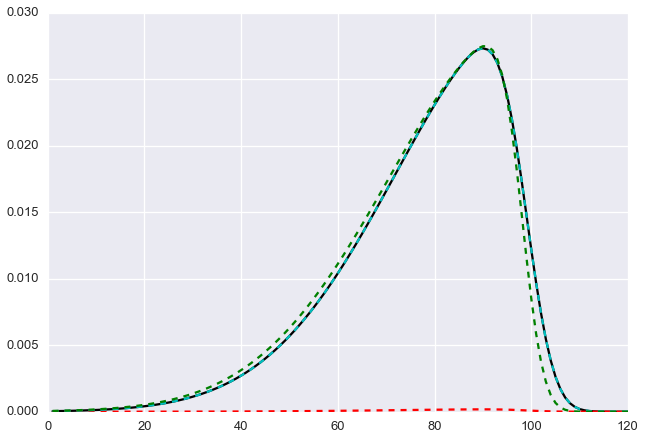

In [16]:
# showing that normalizing gives back the original distribution 
# so the thalamus factor doesn't make a difference if we normalize the output
X = prior[pred_index, :]
U = prior[1, :]
Y = X*0.00645
Z = Y/sum(Y)
plt.plot(thetas, X, 'k-')
plt.plot(thetas, Y, 'r--')
plt.plot(thetas, Z, 'c--')
plt.plot(thetas, U, 'g--')

In [214]:
from nengo.utils.progress import ProgressTracker
import math

# Function to compute the likelihood of each  
# 'x' in the Sample X (x_vector)
def compute_lik(x_vector):
    lik = np.zeros((len(x_vector), max_age))
    i = 0
    #count = 0
    for obs in x_vector:
        #if int(obs) > 120:
        #    obs = 120   
        #    count = count + 1 
        lik[i,:] = likelihood(obs)    #pXZ
        i = i+1
    #print "Count samples above 120: ", count    
    return lik    


def ctx_to_bg(x):
    # scale x such that all  
    # why does x sometimes have all equal elements??
    global spy
    if x.any():
        new_xmax = 1
        new_xmin = 0
        sigma_sq = 0.2*0.2
        x = 1/np.sqrt(2*3.14*sigma_sq) *  np.exp( -1*np.power(x-0.5,2) / (2*sigma_sq) )
        print "\n Gaussian \n", x
        x_min = np.min(x)
        x_max = np.max(x)
        if x_min != x_max:
            spy = [x_min, x_max, x] 
            x = (new_xmax - new_xmin)/(x_max - x_min)*(x - x_min)+ new_xmin 
        else:
            #all elements in the list are equal
            x = x/len(x)
    return x
    
    
estimate_list = []
global total_l, total_s
total_l = 0
total_s = 0
# Online EM where the stored terms are decayed away
# Adding iterations for each example (1) similar to STM cycling
# around hippocampus while being consolidated in the LTM.
# 1) Inner terations: As each example comes in, we update the stored 
# terms and  iterate 'num_inner_iter' times for each individual example.
# 2) Outer Iterations: After all examples have been received, we repeat the 
# entire process/iterate by reusing the same set of examples 'num_iter' times.
# This might be similar to refelcting on past experiences etc.

# no of iterations per sample really matter
# no of outer iterations don't seem to make much difference
def stepwise_em_iterative(x, num_iter=1, num_inner_iter=5): #num_iter=8
    _pXZ = compute_lik(x)
    a = np.random.randint(0, M) 
    #print "start: ", a           
    best_a = None
    best_utility = float('-inf')
    flag = 0
    
    S = np.zeros(M)   # sufficient statistics
    k = 0             # number of updates made to S so far
    beta = 0.65        # 1 gave 40% and 0.5 gave 98% accuracy
    _pXZ_list = list(enumerate(_pXZ))

    iterations = 0
    current_guess = -1
    guess_counter = 0
    
    for r in range(num_iter):
        np.random.shuffle(_pXZ_list) 
        flag = 0
        for i, p in _pXZ_list:
            for _ in range(num_inner_iter): 
                L = np.zeros(M)
                pxz = p * pZA[a, :]
                L += (pxz / np.sum(pxz)).dot(logpZA.T/10.0)
                
                gamma = np.power(float(k+2), -beta)  
                k = k + 1
                
                # gamma*L goes down over time
                # (1-gamma)*S goes up over time
                # S first goes up a bit ,and then stabilizes
                S = gamma*L + (1-gamma)*S
                #print L
                
                max_a = a = np.argmax(S) 
                estimate_list.append(max_a)
                
                if current_guess == max_a:
                    guess_counter = guess_counter + 1
                else:
                    guess_counter = 0
                    
                #if guess_counter >= 30:
                #    probably stuck in local minima
                #    a = np.random.randint(0, M)
                    #print "Total interations: ", iterations
                    #print "max_a in: ", max_a
                    #return max_a
                    
                #print max_a
                current_guess = max_a
                iterations = iterations + 1
        
    
    #print "\n Final max_a: ", max_a   
    global total_l, total_s
    err = rmse(pZA[a, :], pZA[pred_index, :])
    if err > 0.003:
        total_l = total_l + 1
    else:
        total_s = total_s + 1
    return max_a


'''
if L[max_a] > best_utility:
    best_a = max_a
    best_utility = L[max_a]

if prev_max == max_a:
    L[a] = np.min(L)
    a = np.argmax(L)
    if a == best_a:
        break 
prev_max = max
'''


# Accuracy defined based on +/2 withing the optimal value
def grade_solution(f, n_trials, n_samples, name=None, plot=True):
    X = draw(n_trials, n_samples)
    #plt.figure()
    #plt.plot(X[0], 'ro')
    
    correct = 0
    err = np.empty(n_trials)
    with ProgressTracker(1, True, "Initializing"): pass  # Hack to fix bug
    with ProgressTracker(n_trials, True, name) as progress:
        for j in range(n_trials):
            #print "X, alpha: ", X[j], alpha[j]
            a_est = f(X[j])
            if a_est == pred_index:
            #if a_est >= loc-2 and a_est <= loc+2: 
                correct += 1    
            err[j] = rmse(pZA[a_est, :], pZA[pred_index, :]) 
            progress.step()
    acc = correct / float(n_trials)
    #print ("%s (Accuracy = %.3f)" % (name, acc))
    
    if plot:
        plt.figure()
        plt.title("%s (Accuracy = %.3f)" % (name, acc), fontsize=18)
        plt.plot(err, 'o')
        sns.set_style('darkgrid')
        plt.xlabel("number of trials", fontsize=18)
        plt.ylabel("RMSE", fontsize=18)
        sns.despine(offset=10)
        plt.show()
    return acc


def rmse(predictions, targets):
    return  np.sqrt(((predictions - targets) ** 2).mean()) #/ predictions.mean() 

20
8


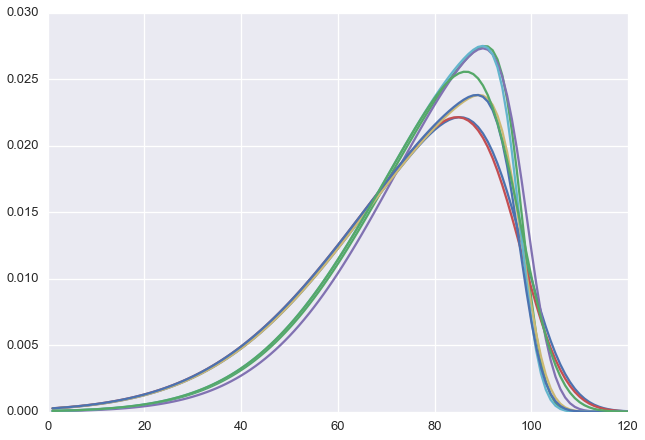

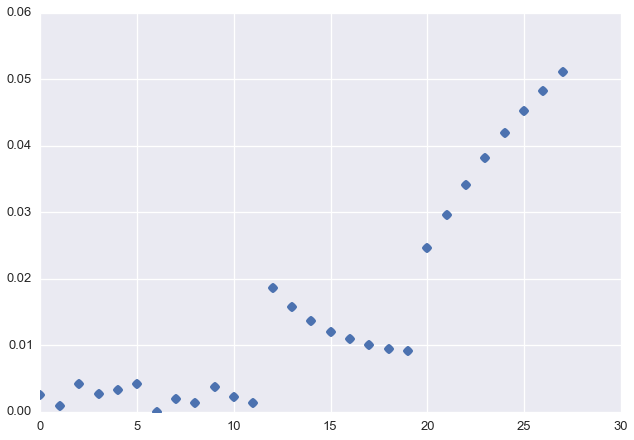

In [215]:
count_g = 0
count_s = 0
total = M
err = np.empty(total)
plt.figure()
for i in range(total):
    b = rmse(pZA[i, :], pZA[pred_index, :])
    err[i] = b
    #print b
    if b > 0.003:
        count_g = count_g + 1
    else:
        plt.plot(thetas, pZA[i, :])
        count_s = count_s + 1
plt.figure()
plt.plot(err, 'o')    
print count_g
print count_s

There are two ways of evaluating these different algorithms. One is accuracy i.e., number of times the algorithm converges to the optimal value which is 95. Second, how close the convergence values are to the optimal value. I think its reasonable if the algorithm converges to values close to the optimal value, since they will lead to priors which are close, and hence can lead to similar samples $X$.

Initializing finished in 0:00:01.                                               
Stepwise Iterative EM finished in 0:00:01.                                      


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less


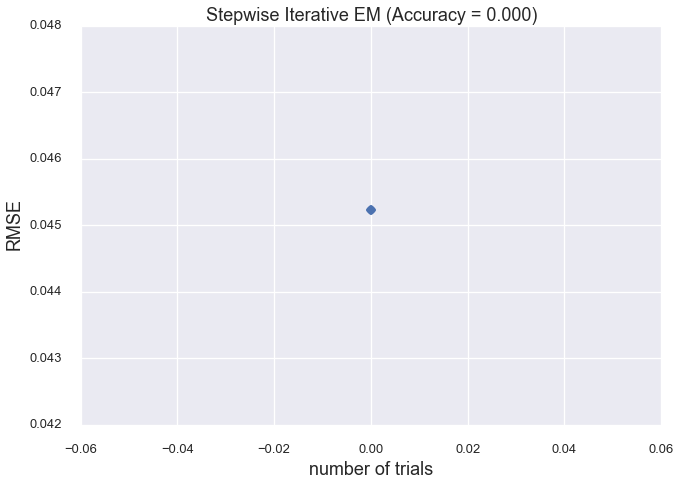

0.0

In [239]:
estimate_list = []
total_l = 0
total_s = 0
grade_solution(stepwise_em_iterative, n_trials=1, n_samples=1, name="Stepwise Iterative EM")

In [217]:
print "Larger: ", total_l
print "Smaller: ", total_s

Larger:  691
Smaller:  309


0.0


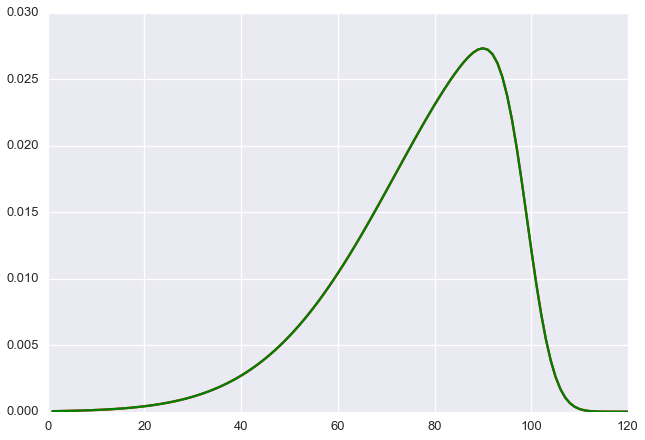

In [177]:
idx = 6
plt.figure()
plt.plot(thetas, pZA[idx, :], 'r')
plt.plot(thetas, pZA[pred_index, :], 'g')
print rmse(pZA[idx, :], pZA[pred_index, :])

In [ ]:
plt.figure()
plt.plot(thetas, pZA[147, :], 'r')
#plt.plot(thetas, pZA[21, :], 'r')
#plt.plot(thetas, pZA[88, :], 'r')
#plt.plot(thetas, pZA[45, :], 'r')
plt.plot(thetas, pZA[pred_index, :], 'g')

#alpha = np.random.uniform(0, 130, 25)    #loc or shift
#alpha2 = np.random.uniform(0, 57, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-5, -7, 2)

test = skew_gauss(-6, 21, 10) 
#mid = 60
test = test/sum(test)
#plt.plot(thetas, test, 'k')

print "RMSE: ", rmse(pZA[147, :], pZA[pred_index, :])

print "Mean: ", pZA[pred_index, :].mean()
print alpha[0], alpha2[0], alpha3[0]

In [ ]:
#*************************************************************************#

## FIRST TEST ##
#alpha = np.random.uniform(89, 109, 10)    #loc or shift
#alpha2 = np.random.uniform(27, 37, 10)    #scale 
#alpha3 = np.random.uniform(-8, -4, 1)     #skew

#total_s = 33/34  <= 0.004
#total_l = 67/66  > 0.004

#total_s = 60  <= 0.005
#total_l = 40  > 0.005

#*************************************************************************#

## SECOND TEST ##
#alpha = np.random.uniform(79, 109, 6)    #loc or shift
#alpha2 = np.random.uniform(7, 37, 6)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew
#total_s = 9  <= 0.005
#total_l = 91  > 0.005

#*************************************************************************#

## THIRD TEST ##
#alpha = np.random.uniform(91, 107, 6)    #loc or shift
#alpha2 = np.random.uniform(19, 35, 6)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

# with 1000 samples
#total_s = 54  <= 0.005
#total_l = 46  > 0.005

# With 100 samples
#total_s = 50  <= 0.005
#total_l = 50  > 0.005

#*************************************************************************#

## FOURTH TEST ##
#alpha = np.random.uniform(87, 109, 10)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 10)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

# With 100 samples
#total_s = 61  <= 0.005
#total_l = 39  > 0.005

#total_s = 85  <= 0.005
#total_l = 15  > 0.005


# With 1000 samples
#total_s = 81  <= 0.005
#total_l = 19  > 0.005

# With 5000 samples
#total_s = 87  <= 0.005
#total_l = 13  > 0.005

# with 20 samples (5 inner iter)
#total_s = 60  <= 0.005
#total_l = 40  > 0.005

# with 100 samples (5 inner iter)
#total_s = 72  <= 0.005
#total_l = 28  > 0.005


# with 500 samples (5 inner iter)
#total_s = 89  <= 0.005
#total_l = 11  > 0.005
# most of them near 0.003

# with 800 samples (5 inner iter)
#total_s = 91  <= 0.005
#total_l = 9  > 0.005
# most of them near 0.003

# not much difference from 800 to 1000

#*************************************************************************#

## FIFTH TEST ##
#alpha = np.random.uniform(95, 103, 4)    #loc or shift
#alpha2 = np.random.uniform(23, 31, 4)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

# With 100 samples, inner iter = 5
#total_s = 33  <= 0.002
#total_l = 67  > 0.002

# With 300 samples, inner iter = 5
#total_s = 33  <= 0.002
#total_l = 67  > 0.002

# With 1000 samples, inner iter = 5
#total_s = 40  <= 0.002
#total_l = 60  > 0.002
# all mostly below 0.003

# With 5000 samples, inner iter = 5
#total_s = 38  <= 0.002
#total_l = 62  > 0.002
# all mostly below 0.003

# not much improvement happening with increasing samples in this case

#*************************************************************************#

## SIXTH TEST ##
#alpha = np.random.uniform(89, 109, 6)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 6)    #scale 
#alpha3 = np.random.uniform(-8, -4, 1)     #skew

# with 100 samples, inner iter = 5
#total_s = 49  <= 0.002
#total_l = 51  > 0.002

#*************************************************************************#

## ************* ##
## SEVENTH TEST ##
# inner iterations = 5
# MAX RMSE is only around 0.003

#alpha = np.random.uniform(94, 102, 4)    #loc or shift
#alpha2 = np.random.uniform(23, 32, 4)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

# with 20 samples, inner iter = 5
#total_s = 51  <= 0.002
#total_l = 49  > 0.002
# almost same result inner iterations = 1 (59, 41)


# with 100 samples, inner iter = 5
#total_s = 87  <= 0.002
#total_l = 13  > 0.002
# almost same result inner iterations = 1

# with 1000 samples, inner iter = 5
#total_s = 98  <= 0.002
#total_l = 2  > 0.002
# In most of the cases, it actually converged to the right one
# same result inner iterations = 1

# with 5000 samples, inner iter = 5
#total_s = 100  <= 0.002
#total_l = 0  > 0.002
# Infact almost all of them converged to the right one
# same result inner iterations = 1

#*************************************************************************#

## EIGHTTH TEST ##
# inner iterations = 1

#alpha = np.random.uniform(89, 109, 10)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 10)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

# inner iter = 1
# with 100 samples
#total_s = 58  <= 0.003
#total_l = 42  > 0.003

# inner iter = 10
# with 100 samples
#total_s = 61  <= 0.003
#total_l = 39  > 0.003

# inner iter = 20
# with 100 samples
#total_s = 71  <= 0.003
#total_l = 29  > 0.003

#*************************************************************************#

## NINTH TEST ##
#alpha = np.random.uniform(92, 104, 5)    #loc or shift
#alpha2 = np.random.uniform(21, 34, 5)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)     #skew

# with 100 samples I am only getting around 50-50 performance

# inner iter = 5
# with 1000 samples
#total_s = 77/79  <= 0.002
#total_l = 23/21  > 0.002

# inner iter = 2
# with 1000 samples
#total_s = 52  <= 0.002
#total_l = 48  > 0.002

#*************************************************************************#

## TENTH TEST ##



#inner iter = 20
# with 1000 samples
#total_s = 51  <= 0.003
#total_l = 49  > 0.003

#inner iter = 1
# with 1000 samples
#total_s = 51  <= 0.003
#total_l = 49  > 0.003

#inner iter = 5
# with 1000 samples
#total_s = 63  <= 0.003
#total_l = 37  > 0.003

#inner iter = 10
# with 1000 samples
#total_s = 77  <= 0.003
#total_l = 23  > 0.003

#*************************************************************************#
# s-l
# 30-60/56-44 for inner iter = 10
# 59-41 for inner iter = 1
# 54-46/59-41 for inner iter = 5
# 57-43 for inner iter = 20
# 57-43 for inner iter = 15

#*************************************************************************#
# FINAL:
# With 200 samples and inner iter = 5
# s-l = 80-20 ratio (threshold 0.003)
# Increasing inner iter doesn't help, but lowering it to 1 makes it worse

#alpha = np.random.uniform(90, 105, 10)    #loc or shift
#alpha2 = np.random.uniform(20, 35, 10)    #scale 
#alpha3 = np.random.uniform(-8, -4, 2)

#In search space
#145 > 0.003
#55 <= 0.003

In [ ]:
## NOTE: logpZA is negative
print (pxz / np.sum(pxz)).dot(logpZA.T/10.0)

In [ ]:
print logpZA.shape

### Nengo model

In [ ]:
import sys
print sys.path

(0, 0.03)

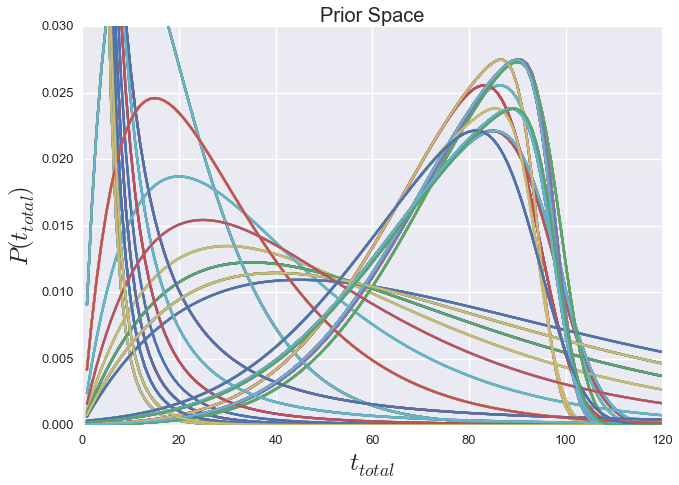

In [43]:
#Define function space for representing priors.
#Priors have values of the order of e-6 so we need to provide special encoders and eval points.
#Furthermore, priors are very high dimensional, so it will be nice to compress them to a lower dimension as well

def prior_space():
    idx = np.random.randint(0, len(pZA))
    return pZA[idx]

import nengo.utils.function_space
nengo.dists.Function = nengo.utils.function_space.Function
nengo.FunctionSpace = nengo.utils.function_space.FunctionSpace

n_basis = 20

space = nengo.FunctionSpace(
        nengo.dists.Function(prior_space),
        n_basis=n_basis)

from copy import deepcopy
space_raw = deepcopy(space.space)

data = space.space.sample(200)
plt.figure()
plt.plot(thetas, data.T)
plt.title("Prior Space", fontsize=20)
plt.xlabel("$t_{total}$", fontsize=25)
plt.ylabel("$P(t_{total})$", fontsize=25)
plt.ylim(0,0.03)

In [251]:
# initial input
global p, i
i = 0
X = draw(1, 1005)
_pXZ = compute_lik(X[0])
p = _pXZ[0]

a =  np.random.randint(0, M) 
L = np.zeros(M)   
pxz = p * pZA[a, :]   # pZA changing every one second, p (likelihood) changing every 20 secs or so. 
input = (pxz / np.sum(pxz))

model = nengo.Network(label='learn prior') # seed=34)#50, seed=29) #50 #24
#model.config[nengo.Ensemble].neuron_type=nengo.Direct() #nengo.LIFRate() 
srch_space = M
global k
gate_input = 0
time = 0
k = 0
beta = 0.65
thal_factor = 0.910 # 0.3429 #0.8544 #0.653 #0.754 #0.684 #0.664  # not needed anymore
global spy
global spy_x
dt = 0.001
with model:
    

    def ctx_drive(t, x):
        "t - current time in ms"
        "x - cortical state in cortex2 ensemble"
        global k, p, i, spy_x
        change_freq = 5
        
        #if t%1 > 0.5:
        #    return 0
        
        # somehow even without adding this, cortical state is maintained during the wta inhibition period.
        # this is because even after inhibition, the cortex1 is not exactly zero
        # I even printed the x value at 2.4 and 2.9 and they are exactly the same.
        # this might have something to do with the node's behaviour in preserving the previous x values
        # if the incoming value is null?? - this happens only in direct mode and the following circuit doesn't
        # work in non-direct mode. never goes inside the if block.
        # return the previous cortical state during the wta inhibition period
        #if not x.any() and t>1:
        #    x = spy_x
        #    #print "nothing"
        #else:    
        #    spy_x = x   
        
              # to push it out of the local minima
        #if t==10:
        #    a =  np.random.randint(0, M) 
        #    x = pZA[a, :] 
        
        
        # reconstruct the prior back to 120dim space
        # normalize reconstructed prior
        x = np.dot(x, space._basis.T)
        if sum(x) != 0:
            x = x/np.sum(x) 
        
         
        # swap
        if t%1<0.5:
            if t<1:
                spy_x = x
            else:    
                temp = x
                x = spy_x
                spy_x = temp
                    
        #if t==2.4 or t==2.9:
        #    print x  # they are infact same
        
        
        # every 'change_freq' iterations, a new sample comes in (so the likelihood changes)
        if t%change_freq == 0 and t!=0:
            i = i+1
            p = _pXZ[i]
        

        # updating every 1 second, so each iteration is 1s 
        if t%1 == 0 and t!=0:
            k = k+1         
        
        nk = np.power(float(np.floor(k)+2), -beta)
        if t<1:
            return nk*input
        
            
        # every 1 second, a new prior (from previous iteration) is used to update ctx
        # p is the likelihood and x is the prior selected from previous iteration
        pxz = p * x   
        if pxz.any():
            pxz = pxz / np.sum(pxz)
        else:
            # pxz has all zeros
            #print "pxz = zero"
            pass
            
            
        return nk*pxz
     
            
    def ctx_to_bg(t, x):
        # scale x such that all  
        # why does x sometimes have all equal elements??
        global spy
        if x.any():
            new_xmax = 1
            new_xmin = 0
            # this gaussian thing makes the result worse - is probably not scaling proportionately
            #sigma_sq = 0.2*0.2  # both 0.2 and 0.3 work but shouldn't be >= 0.4
            #x = 1/np.sqrt(2*3.14*sigma_sq) *  np.exp( -1*np.power(x-0.5,2) / (2*sigma_sq) )
            x_min = np.min(x)
            x_max = np.max(x)
            if x_min != x_max:
                spy = [x_min, x_max, x] 
                x = (new_xmax - new_xmin)/(x_max - x_min)*(x - x_min)+ new_xmin 
            else:
                #all elements in the list are equal
                x = x/len(x)
        return x
    
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Cortical Processing
    
    
    # node providing cortical input to the model - sample data as sensory input 
    cortex_in = nengo.Node(output=ctx_drive, size_out=max_age, size_in=space.n_basis)
    
    # Cortex representing the summary statistics of current and previous iterations
    # This is the input for wta network
    # SS-NN
    ensemble_ctx = nengo.networks.EnsembleArray(n_neurons=150, n_ensembles=srch_space, neuron_type=nengo.LIF()) 
    for ens in ensemble_ctx.all_ensembles:
        ens.encoders = nengo.dists.Choice([[-1]])  #UniformHypersphere()  #
        ens.radius = 0.6
        
    # connect sensory input to cortex
    # logpZA.T => (srch_space, max_age)
    # Divide by 10 to make it representable by neurons.
    nengo.Connection(cortex_in, ensemble_ctx.input, transform=logpZA/10.0)
    
        
    # Notes about ensemble_ctx:
    # 100 neurons work accurate with LIFRate neurons
    # However, with 100 neurons LIF neurons don't represent accurately need upto 500 LIF neurons  
    # -ve encoders work much better since the values represented by this ensemble are always negative
     
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Winner take all network - Independant Accumulator
    # needs to be reset through inhibition before every iteration.
    
    
    # SS-NN
    wta = IA(d=srch_space, n_neurons=200, dt=dt)
    wta.x.add_neuron_input()

    # min'm 3s needed for inhibition
    def inhib(t):
        if t%1 > 0.5:
            return 2.0 
        else:
            return 0
    
    #Connecting inhibit population to error population
    inhibit = nengo.Node(inhib)
    nengo.Connection(inhibit, wta.x.neuron_input, 
                     transform=[[-2]] * wta.x.n_neurons_per_ensemble * wta.x.n_ensembles, synapse=0.01)
    
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Prepare input for wta network
    # Input should be positive and scaled to span the entire range 
    # from 0-1 in order to space apart the competing values
    
    
    # node providing a constant bias of 1 to convert the values in 'ensemble_ctx' 
    # from -ve to +ve before wta input
    node_const = nengo.Node(output=np.ones(srch_space), size_out=srch_space)
    
    # node used for scaling the values in 'ensemble_ctx' to span entire range from 0-1
    scale_node = nengo.Node(output=ctx_to_bg, size_in=srch_space, size_out=srch_space)
    
    # node just for adding the bias and the input from memory network
    node_ctx = nengo.Node(size_in=srch_space, size_out=srch_space)
    
    # first add bias
    nengo.Connection(ensemble_ctx.output, node_ctx, synapse=0.02)
    nengo.Connection(node_const, node_ctx)
    
    # scale the values only once the bias has been added
    nengo.Connection(node_ctx, scale_node) #SS
    nengo.Connection(scale_node, wta.input)

    
    ### ------------------------------------------------------------------------------------------------------- ###  
    

    # These connection leads to (1-n(k))u
    # store bg output to memory (u = memory)
    def mem_to_bg(t, x):
        if t<1:
            return 0
        #if t%1 > 0.5:
        #    return 0
        global k
        nk = np.power(float(np.floor(k)+2), -beta)
        return x * (1 - nk)  # this will be zero for the first 0.5 seconds since x is zero
      
    
    def gate_mem2(t, x):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "close the gate in first half, open in second"
        gate_input = 1
        if t%1 >= 0.5 and t%1 < 1:
            gate_input = 0
        elif t%1 >= 0 and t%1 < 0.5:
            gate_input = 1
        return gate_input 
    
    
    def gate_mem1(t, x):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "open the gate in first half, close in second"
        gate_input = 1
        if t%1 >= 0.5 and t%1 < 1:
            gate_input = 1
        elif t%1 >= 0 and t%1 < 0.5:
            gate_input = 0
        return gate_input
    
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Memory Network
    
    # Notes:
    # memory nets can't have direct neurons
    # Don't change the recurrent synapse. Default value of 0.1 is the most stable
    # increasing number of neurons really helps to keep the representation stable
    
    
    # build two working memories
    # SS-NN
    mem_net = nengo.Network()
    mem_net.config[nengo.Ensemble].encoders = nengo.dists.Choice([[-1]]) 
    mem_net.config[nengo.Ensemble].neuron_type = nengo.LIF()
    mem_net.config[nengo.Ensemble].radius = 0.6
    with mem_net:
        memory1 = nengo.networks.InputGatedMemory(n_neurons=200, dimensions=srch_space) 
        memory2 = nengo.networks.InputGatedMemory(n_neurons=200, dimensions=srch_space)
    
    
    gate_in1 = nengo.Node(output=gate_mem1, size_out=1, size_in=1)
    nengo.Connection(gate_in1, memory1.gate)
    
    gate_in2 = nengo.Node(output=gate_mem2, size_out=1, size_in=1)
    nengo.Connection(gate_in2, memory2.gate)
    
    nengo.Connection(ensemble_ctx.output, memory1.input, synapse=0.02)
    nengo.Connection(memory1.output, memory2.input, synapse=0.02)
    
    # node is needed to multiply by updated (1-nk) over time
    node_mem = nengo.Node(output=mem_to_bg, size_in=srch_space, size_out=srch_space)
    nengo.Connection(memory2.output, node_mem, synapse=0.02)  
    nengo.Connection(node_mem, node_ctx)


    ### ------------------------------------------------------------------------------------------------------- ###  
    # Cortex updates at the end of an iteration
    # The winning prior needs to be stored n the cortex but the values
    # are too small, so we need special eval points and encoders.
    # Moreover dimensionality reduction is important here for computational efficiency
    
    
    # ensemble to store the winning prior for the current iteration
    # SS-NN
    # works perfectly in direct mode so no error due to compression
    # error is purely a function of n_neurons in the ensemble
    # n_neurons will also depend on the prior space so finalize in the end
    # for now, just use 1000 neurons
    cortex1 = nengo.Ensemble(n_neurons=1000, dimensions=space.n_basis,
                         encoders=space.project(space_raw),
                         eval_points=space.project(space_raw),
                         neuron_type = nengo.LIF()
                         )  
    
    dummy_ctx = nengo.Ensemble(n_neurons=1000, dimensions=max_age, neuron_type = nengo.Direct())  
    
    def project(x):
        return space.project(x)
    
    
    # pZA.T => (max_age, srch_space)
    # function is applied before the transform when both are on a connection
    nengo.Connection(wta.output, dummy_ctx, transform=pZA.T, synapse=0.02)
    nengo.Connection(dummy_ctx, cortex1, function=project)
    
    # prior is sent to the node 'cortex_in' to be processed 
    # and converted to the posterior.
    nengo.Connection(cortex1, cortex_in)
    
    ### ------------------------------------------------------------------------------------------------------- ###  
    # Probes
    
    # wta 
    wta_doutp = nengo.Probe(wta.output, synapse=0.02)
    wta_statep = nengo.Probe(wta.x.output, synapse=0.02)
    wta_inp = nengo.Probe(wta.input, synapse=0.02)
    
    # ctx 
    cortex1_p = nengo.Probe(cortex1, synapse=0.02)
    ensctx_p = nengo.Probe(ensemble_ctx.output, synapse=0.02)
    node_ctxp = nengo.Probe(node_ctx, synapse=0.02)
    ctx_inp = nengo.Probe(cortex_in, synapse=0.02)
    dummy_ctxp = nengo.Probe(dummy_ctx, synapse=0.02)
    
    # memory
    memory1_ip = nengo.Probe(memory1.input, synapse=0.02)
    memory1_op = nengo.Probe(memory1.output, synapse=0.02)
    memory1_gp = nengo.Probe(memory1.gate, synapse=0.02)
    memory2_ip = nengo.Probe(memory2.input, synapse=0.02)
    memory2_op = nengo.Probe(memory2.output, synapse=0.02)
    memory2_gp = nengo.Probe(memory2.gate, synapse=0.02)
    node_memp = nengo.Probe(node_mem, synapse=0.02)
   

sim = nengo.Simulator(model, dt=dt)  # Create the simulator
sim.run(100)                  # Run it for 1 second    

Building finished in 0:00:04.                                                   
Simulating finished in 0:10:52.                                                 


#### Things to do 
#Representation in ensemble cortex: Done. <br>
#Representation in memory network: Done. <br> 
#Representation in cortex1 - Can be improved upon by providing targetted space. <br>
Seems like there is still some error due to compression as well.

#### Performance metrics
Convergence - % of times it converges. RMSE range. 

In [ ]:
# to check representation of ensemble ctx, mem1 and mem2
# works beautifully with a radius of 0.6, -ve encoders and LIFRate neurons
# Doesn't work very well with LIF neurons though. 

Y = np.dot(sim.data[ctx_inp][3300], logpZA.T/10.0) 
print Y   # expected in ensctx

print sim.data[ensctx_p][3300]
print sim.data[memory1_op][3700]
print sim.data[memory2_op][3900]

(120,)
(120,)


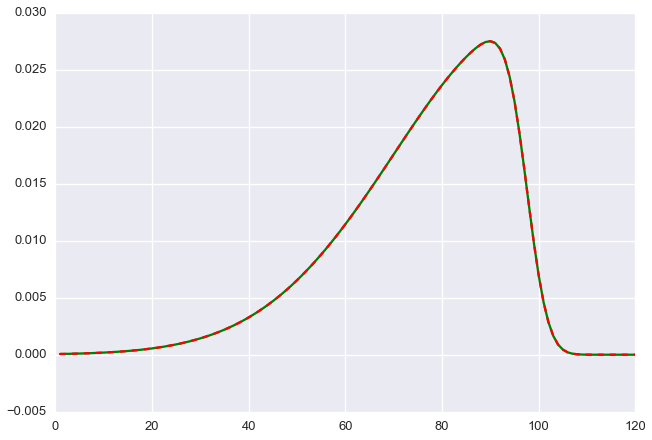

In [230]:
# for testing cortex1 - compression/reconstruction
idx = 1400


thal_output = sim.data[wta_doutp][idx]
winner_idx  =  np.argmax(thal_output)

Z = pZA[winner_idx, :]
U = sim.data[cortex1_p][idx]
recnstct = np.dot(U, space._basis.T)
recnstct = recnstct/np.sum(recnstct)  #normalize reconstructed prior

plt.figure()
plt.plot(thetas, Z, 'g')  # expected
plt.plot(thetas, recnstct, 'r--')  # model obtained

print Z.shape
print recnstct.shape

In [ ]:
# 1
# my concern is that no matter how many samples there are, the attractor is one and model always converges to that
# attractor. Depending on number of iterations, and number of samples, model sometimes convergest to this attractor
# sooner than later, but its always the same attractor in the (10, 10, 2) case.

# 100s with 20 samples and 100s with 100 samples both gave the same result
# seed 43 - converging to index 123, rmse = 0.01032
# seed 22 - converging to index 62, rmse = 0.0047

#2
# with (4,4,2) 5 interations per sample performs better than 1 iterations per sample

In [ ]:
#print input*100
print a
print "number of samples: ", i

(0, 25)

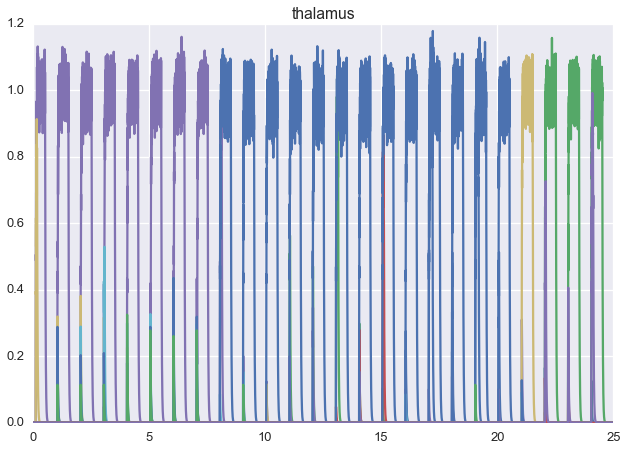

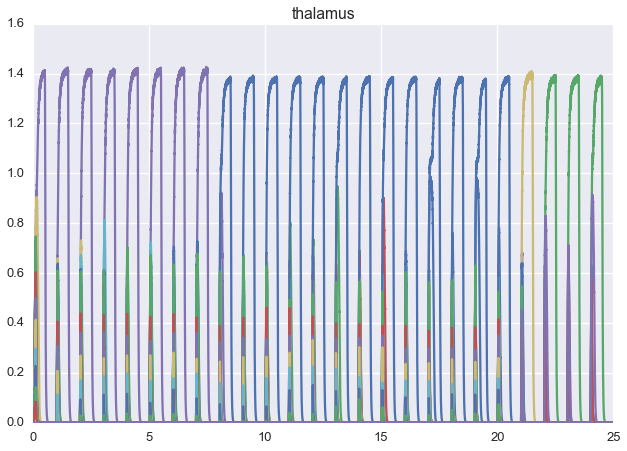

In [252]:
plt.figure()
plt.plot(sim.trange(), sim.data[wta_doutp])
plt.title("thalamus")
plt.xlim(0,25)

plt.figure()
plt.plot(sim.trange(), sim.data[wta_statep])
plt.title("thalamus")
plt.xlim(0,25)


In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model)

Winner index:  1
Prediction index 6
RMSE (model):  0.001345867047
RMSE (actua):  0.000920477745475


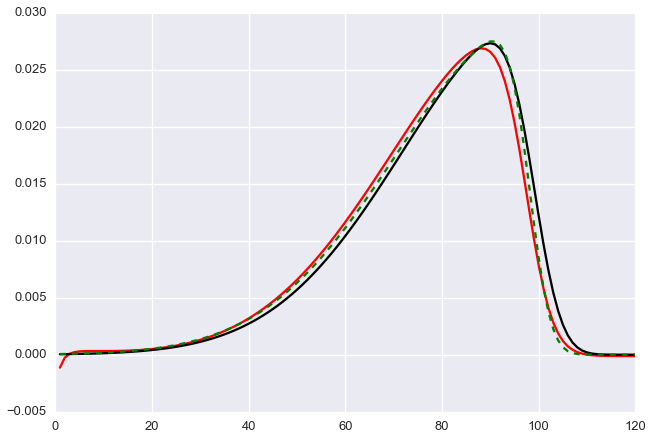

In [254]:
#data = sim.data[cortex_p][-1]   # this looks like a posterior which is expected
idx = -510
wta_output = sim.data[wta_doutp][idx]
winner_idx  =  np.argmax(wta_output)
print "Winner index: ", winner_idx
print "Prediction index", pred_index

test_ind = 1
#data = sim.data[dummy_ctxp][idx]
data = sim.data[cortex1_p][idx]   # cortex - prior representation 
data = np.dot(data, space._basis.T)
data = data/np.sum(data)

print "RMSE (model): ", rmse(data, pZA[pred_index, :])
print "RMSE (actua): ", rmse(pZA[test_ind, :], pZA[pred_index, :])
#print thal_output

#print bg_output[winner_idx[0]]
plt.figure()
plt.plot(thetas, data/sum(data), 'r')
plt.plot(thetas, pZA[pred_index, :], 'k')
plt.plot(thetas, pZA[test_ind, :], 'g--')

# ONE
# Thalamus factor is not needed since I am normalizing the distribution
# coming out which brings it back            to the original distribution

# TWO
# using memories in direct mode works, converges to RMSE 0.003 - not always (sometimes to 0.007)
# but using memories with 500 neurons each is giving RMSE 0.007
# So there might be representation issues.

# THREE
# The above point also means that bg-thal loop seems to be
# working fine. 
# alpha = np.random.uniform(85, 100, 4)    #loc or shift
# alpha2 = np.random.uniform(24, 32, 4)    #scale 
# alpha3 = np.random.uniform(-8, -4, 2)     #skew

In [ ]:
print sim.data[wta_doutp][600]
print np.argmax(sim.data[wta_doutp][600])

print sim.data[wta_doutp][400]
print np.argmax(sim.data[wta_doutp][400])


print sim.data[wta_doutp][2600]
print np.argmax(sim.data[wta_doutp][2600])

print sim.data[wta_doutp][2400]
print np.argmax(sim.data[wta_doutp][2400])

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(12, 1, 1)
plt.plot(sim.trange(), sim.data[cortex_p])
plt.title("Cortex")

plt.subplot(12, 1, 2)
plt.plot(sim.trange(), sim.data[wta_inp])
plt.title("WTA input")

plt.subplot(12, 1, 3)
plt.plot(sim.trange(), sim.data[wta_doutp])
plt.title("WTA output")
#plt.xlim(0,5)

plt.subplot(12, 1, 4)
plt.plot(sim.trange(), sim.data[wta_statep])
plt.title("WTA state")

plt.subplot(12, 1, 5)
plt.plot(sim.trange(), sim.data[memory1_ip])
plt.title("Memory1 input")

plt.subplot(12, 1, 6)
plt.plot(sim.trange(), sim.data[memory1_op])
plt.title("Memory1 output")

'''
plt.subplot(12, 1, 7)
plt.plot(sim.trange(), sim.data[memory1_gp])
plt.title("Memory1 gate")
'''

plt.subplot(12, 1, 8)
plt.plot(sim.trange(), sim.data[memory2_ip])
plt.title("Memory2 input")

plt.subplot(12, 1, 9)
plt.plot(sim.trange(), sim.data[memory2_op])
plt.title("Memory2 output")
'''
plt.subplot(12, 1, 10)
plt.plot(sim.trange(), sim.data[memory2_gp])
plt.title("Memory2 gate")
'''

plt.subplot(12, 1, 10)
plt.plot(sim.trange(), sim.data[node_ctxp])
plt.title("Cortex Node")


plt.subplot(12, 1, 7)
plt.plot(sim.trange(), sim.data[ensctx_p])
plt.title("Ensemble Ctx")


plt.subplot(12, 1, 11)
plt.plot(sim.trange(), sim.data[cortex1_p])
plt.title("Cortex1");

plt.subplot(12, 1, 12)
plt.plot(sim.trange(), sim.data[ctx_inp])
plt.title("Cortex_in")


sometimes the prior found by the model at a particular index is not the same as the original prior at that index.
This might be because thalamus is not just selecting one index but is kind of the weighted sum of 2 or more inices in certain instances.

In [ ]:
test = sim.data[wta_doutp]
for i in range(len(test)):
    print np.argmax(test[i])

In [ ]:
test = wta_doutp

data = sim.data[cortex1_p][400]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][400])

data = sim.data[cortex1_p][1200]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][1200])

data = sim.data[cortex1_p][2000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][2000])

data = sim.data[cortex1_p][2800]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][2800])

data = sim.data[cortex1_p][3600]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][3600])

data = sim.data[cortex1_p][4400]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][4400])

data = sim.data[cortex1_p][5200]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][5200])

data = sim.data[cortex1_p][6000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][6000])

data = sim.data[cortex1_p][4000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][4000])

data = sim.data[cortex1_p][12000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][12000])

data = sim.data[cortex1_p][20000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][20000])

data = sim.data[cortex1_p][28000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][28000])

data = sim.data[cortex1_p][36000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][36000])

data = sim.data[cortex1_p][44000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][44000])

data = sim.data[cortex1_p][52000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][52000])

data = sim.data[cortex1_p][60000]   # cortex - prior representation before normalization
print "RMSE (model): ", rmse(data/sum(data), pZA[pred_index, :])
print np.argmax(sim.data[test][60000])

# Notes

### Erlang and Power law priors

In [ ]:
# Erlang
# scale = 1/lambda = mu = beta
# k = a

plt.figure()
a = 2  # should be a positive integer
loc = 0
for scale in [10, 18, 30]: #, 40, 52, 80]:
    P = [(st.erlang.pdf(p, a=a, loc=loc, scale=scale)) for p in thetas]
    P = P/sum(P)
    print "RMSE: ", rmse(P, prior[pred_index, :])
    plt.plot(thetas, P, 'b--')
   

In [ ]:
# Power Law/ Pareto

plt.figure()
loc = 0 #-7.5
scale = 7 #12
for b in [1, 1.5, 2, 2.43]: #, 3, 4, 5]:
    P = [(st.pareto.pdf(p, b=b, loc=loc, scale=scale)) for p in thetas]
    P = P/sum(P)
    print "RMSE: ", rmse(P, prior[pred_index, :])
    plt.plot(thetas, P, 'b--')

#plt.xlim(0,25)    


### Why the output from wta shouldn't be normalized.

Turns out that normalizing actually changes the distribution. There is no need to normalize anyways. <br> <br>
Another things is that sometimes you might see two winners as the output of wta network, but as long as these two winners resolve to one winner before the end of first half (of the current second), then its fine. It just means that wta networks takes some time to settle to one winner. The prior used in the next iteration is the winner recorded at 0.5s mark in each iteration.

In [ ]:
idx = 8500  # choose an index within first half of any second (0.5-1), otherwise wta is inhibited
#print thal_output = sim.data[wta_doutp]
thal_output = sim.data[wta_doutp][idx]
winner_idx  =  np.argmax(thal_output)

X = sim.data[cortex1_p][idx]
Z = Z/sum(X)

plt.figure()
plt.plot(thetas, X, 'r')  # non-normalized wta output
#plt.plot(thetas, Z, 'b')  # normalized wta output     (might have to comment this one out to see other two)
plt.plot(thetas, pZA[winner_idx, :], 'k--')  # actual output based on winner index




##### WTA IA network

In [ ]:
model_bg = nengo.Network(label='test', seed=15)
dim = 4
dt = 0.001
with model_bg:
      
    def input(t):
        return [0.8, 0.83, 0.4, 0.2]
        if t%1 <= 0.7: 
            if int(t)%2 == 0:    
                return [0.3, 0.5, 0.7, 0.9]
            else:
                return [0.8, 0.6, 0.4, 0.2]
        else:
            return 0.5  # test non-zero input during inhibition
             
    
    input_test = nengo.Node(output=input, size_out=dim)
    #wta = LCA(d=dim, n_neurons=200, dt=dt)  # LCA has the same problem as the bg-thal WTA
    wta = IA(d=dim, n_neurons=200, dt=dt)
    wta.x.add_neuron_input()

    # Creating the input to wta network
    nengo.Connection(input_test, wta.input, synapse=0.01)
    

    # min'm 3s needed for inhibition
    def inhib(t):
        if t%1 > 0.7:
            return 2.0 
        else:
            return 0
    
    #Connecting inhibit population to error population
    inhibit = nengo.Node(inhib)
    nengo.Connection(inhibit, wta.x.neuron_input, 
                     transform=[[-2]] * wta.x.n_neurons_per_ensemble * wta.x.n_ensembles, synapse=0.01)
    
    
    
    
    wtain_p = nengo.Probe(wta.input, synapse=0.03)
    wtaout_p = nengo.Probe(wta.output, synapse=0.03)
    wtastate_p = nengo.Probe(wta.x.output, synapse=0.03)
    input_p = nengo.Probe(input_test, synapse=0.03)

    
sim = nengo.Simulator(model_bg, dt=dt)  # Create the simulator
sim.run(4.0) 

In [ ]:
#[0.8, 0.83, 0.4, 0.2]
test = sim.data[wtastate_p][-1]
print test

In [ ]:
plt.figure()
plt.plot(sim.trange(), sim.data[wtain_p])
plt.title("WTA input")

plt.figure()
plt.plot(sim.trange(), sim.data[wtaout_p])
plt.title("WTA output")

plt.figure()
plt.plot(sim.trange(), sim.data[wtastate_p])
plt.title("WTA state")

In [ ]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model_bg)

##### Basal ganglia input sum

In [ ]:
# bg-thal network works for both positive and negative values,
# it also works for a mix of positive and negative values,
# however its sensitive to the difference between the values
# for radius of 1, difference of 0.2 always gives accurate results
# for radius of 10, difference needs to be higher
model_bg = nengo.Network(label='test', seed=15)
dim = 4
model_bg.config[nengo.Ensemble].radius=1 #nengo.Direct() #nengo.LIFRate() 

with model_bg:
      
    def input(t):
        #return [0.8, 0.5, 0.6, 0.2]
        if t%1 >0 and t%1 < 0.5:
            return [0.2, 0.5, 0.6, 0.9]
        else:
            return [0.8, 0.84, 0.76, 0.72]
            
    
    vec = [x*-1 for x in [-0.8, -0.4, -0.6, -0.2]]
    input_test = nengo.Node(output=input, size_out=dim)


    # Creating the basal ganglia and the thalamus network
    BG = nengo.networks.BasalGanglia(dimensions=dim, net=model_bg, )  
    thal = nengo.networks.Thalamus(dimensions=dim, net=model_bg, )
    nengo.Connection(BG.output, thal.input, synapse=0.01)
    nengo.Connection(input_test, BG.input, synapse=0.01)
    
    
    bginput_p = nengo.Probe(BG.input, synapse=0.03)
    bgoutput_p = nengo.Probe(BG.output, synapse=0.03)
    thalout_p = nengo.Probe(thal.output, synapse=0.03)
    input_p = nengo.Probe(input_test, synapse=0.03)

    
sim = nengo.Simulator(model_bg)  # Create the simulator
sim.run(4.0) 

In [ ]:
plt.figure()
plt.plot(sim.trange(), sim.data[bginput_p])
plt.title("BG input")

plt.figure()
plt.plot(sim.trange(), sim.data[bgoutput_p])
plt.title("BG output")

plt.figure()
plt.plot(sim.trange(), sim.data[thalout_p])
plt.title("Thalamus output")

In [ ]:
test =  bginput_p  #, thalout_p

thal_output = sim.data[input_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx

thal_output = sim.data[bginput_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx

thal_output = sim.data[bgoutput_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx

thal_output = sim.data[thalout_p][-1]
print thal_output
winner_idx  =  np.argmax(thal_output) 
print "Winner index: ", winner_idx


##### Input gated memory

In [ ]:
## input gated memory
model_mem = nengo.Network(label='test', seed=15)
dim = M
with model_mem:
    
    def gate_mem(t):
        "gate 0 - gate is open"
        "gate 1 - gate is closed"
        "open the gate in first half, close in second"
        gate_input = 1
        if t%1 < 0.5:
            return 0
        elif t >= 0.5:
            return 1
    
    gate = nengo.Node(output=gate_mem)
    input_test = nengo.Node(output=lambda t: (-0.365, -0.458) if int(t)%2 == 0 else (-0.263, -0.352), size_out=2)
    #input_test = nengo.Node(output=0.632478, size_out=1)
    memory = nengo.networks.InputGatedMemory(n_neurons=100, dimensions=2, recurrent_synapse=0.1)
    
    memory2 = nengo.networks.InputGatedMemory(n_neurons=100, dimensions=2, recurrent_synapse=0.1)

    nengo.Connection(gate, memory.gate)
    nengo.Connection(input_test, memory.input, synapse=0.02)
    nengo.Connection(memory.output, memory2.input)
    
    mem_p = nengo.Probe(memory.output, synapse=0.03)
    mem_gp = nengo.Probe(memory.gate, synapse=0.03)
    input_p = nengo.Probe(input_test, synapse=0.03)

    
    
sim = nengo.Simulator(model_mem)  # Create the simulator
sim.run(4.0) 

In [ ]:
print sim.data[input_p][900]

In [ ]:
plt.figure()
plt.plot(sim.trange(), sim.data[input_p])
plt.title("Input")

plt.figure()
plt.plot(sim.trange(), sim.data[mem_p])
plt.title("Input gated memory")

plt.figure()
plt.plot(sim.trange(), sim.data[mem_gp])
plt.title("memory gate")

##### Changing the range

In [ ]:
# changing the range does distribute the 
# values throughout that new range
x = [0.27, 0.256, 0.29, 0.35, 0.32]
new_xmax = 1
new_xmin = 0
x_min = np.min(x)
x_max = np.max(x)
x = (new_xmax - new_xmin)/(x_max - x_min)*(x - x_min)+ new_xmin
print x

#### matrix operations

In [ ]:
## just showing here that Matrix (A.B)*n = A.(B*n)
A = np.ones((1,3))*5
B = np.ones((3, 5))
C = np.dot(A, B)
print C

A = np.ones((1,3))
B = np.ones((3, 5))
C = np.dot(A, B)
print C*5

##### Nengo model ends

In [ ]:
plt.figure()
plt.plot(np.arange(len(estimate_list)), 99*np.ones((len(estimate_list))), 'r')
plt.plot(np.arange(len(estimate_list)), estimate_list)
#plt.xlim(800200 - 800, 800200)
#plt.xlim(430000, 488000)
#plt.ylim(80, 120)
plt.xlabel("iteration no.", fontsize=25)
plt.ylabel("estimate", fontsize=25)

In [ ]:
# Plot the search space - priors we are searching over
plt.figure()
plt.title("Family of Priors (Search Space)")
for loc_value in alpha:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)
    

# Plot the priors with value of loc within +/-3 of 95
plt.figure()
plt.title("Priors found")    
loc_list = [loc-2, loc-1, loc, loc+1, loc+2]
for loc_value in loc_list:
    prior = skew_gauss(skew, loc_value, scale)
    plt.plot(thetas, prior)

In [ ]:
# raw empirical evaluation

# Compute the prior for all values of alpha
# this is our search space
#alpha = np.random.uniform(lower, upper+1, 10)    #loc or shift
#alpha2 = np.random.uniform(10, 40+1, 10)         #scale 
#alpha3 = np.random.uniform(-6, -6, 10)   #(-10, 5+1, 5)         #skew

# This setting gives rmse upto 0.006 which is too high
# reasonable performance if two parameters are fixed (rmse 0.002 - 0.004)
#alpha = np.random.uniform(89, 109, 10)    
#alpha2 = np.random.uniform(17, 37, 10)  
#alpha3 = np.random.uniform(-6, -6, 1) 

# This setting gives rmse upto 0.01 which is too bad
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-4, 4, 5)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.007 which is too high
# note that reducing the range of the scale really helped
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-4, -8, 5)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.004 which is not bad
# the problem is that I can't really keep the skew parameter 
# fixed ...lets try a small variation.
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.01 which is very bad
# so for skew, I can't have very far off options, otherwise
# it converges to them too. - BUT WHY???
# Lets check this for scale and shift too.
#alpha = np.random.uniform(89, 109, 5)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(4, 8, 1)   #(-10, 5, 20)           #skew

# This setting gives rmse upto 0.02 which is very bad
# converges on a distribution which is wayy far off. 
# seems like it might be because I am only using 5 values
# for each, so convergence path might not be straightforward.
# Increasing it from 5 to 10 now
#alpha = np.random.uniform(20, 50, 5)    #loc or shift
#alpha2 = np.random.uniform(7, 17, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# didn't work, again rmse 0.02
#alpha = np.random.uniform(20, 50, 10)    #loc or shift
#alpha2 = np.random.uniform(7, 17, 10)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# here I changed the range of scale, as a results, the 
# resulting distributions don't have much overlap with 
# the optimal distribution. So convergest to the optimal
# always: both with 5 and 10 samples for scale and shift.

# Changing range of skew fto (4,8,1) agains brings back
# rmse to 0.06 due to much more overlap of distributions.
# even increasing the number of samples to 8000, results 
# stay the same. 
#alpha = np.random.uniform(20, 50, 5)    #loc or shift
#alpha2 = np.random.uniform(37, 57, 5)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# rmse = 0.02 - terrible, converging to a distributions 
# with almost no overlap.
#alpha = np.random.uniform(0, 140, 10)    #loc or shift
#alpha2 = np.random.uniform(0, 47, 10)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# rmse = between 0.002 and 0.003 - pretty good
# my conclusion is that maybe more steps are needed i.e 10 samples
#alpha = np.random.uniform(90, 105, 10)    #loc or shift
#alpha2 = np.random.uniform(20, 35, 10)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 2)   #(-10, 5, 20)           #skew

# rmse = 0.001 pe aa gayee due to decreasing the number of
# samples from 10 to 5

# 15 samples  => rmse upto 0.02
# 10 samples  => rmse upto 0.03
# 5 samples  => rmse upto 0.03
# 25 samples => rmse upto 0.01 but also as low as 0.0007 in 3 out of 5 samples
# so definitely having more samples helps presumably to traverse the space.
#alpha = np.random.uniform(90, 105, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 35, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# in this case I have increased the range of parameters
# shift and scale. 
# rmse => 0.008, 0.002, 0.001, 0.01, 0.002
# so seems like increasing the samples helps even if the range is increased
#alpha = np.random.uniform(70, 115, 25)    #loc or shift
#alpha2 = np.random.uniform(10, 45, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# On Further expandig the range, rmse => upto 0.02 BAD
#alpha = np.random.uniform(0, 130, 25)    #loc or shift
#alpha2 = np.random.uniform(0, 57, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)           #skew

# Now I am just gonna find the optimal range that works
# provided all three parameters are varied
# okay for this combo, already rmse => 0.06
# which is pretty bad, but to be fair the predicted distribution
# shouldn't even be in the search space. So the next task is to find a 
# sensible range for each of these hyperparameters.
#alpha = np.random.uniform(0, 130, 25)    #loc or shift
#alpha2 = np.random.uniform(0, 57, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-5, -7, 2)   #(-10, 5, 20)           #skew

# rmse goes to 0.008 once in 5 times
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, 5, 2)   #(-10, 5, 20)           #skew

# this one is converging to the optimal sometimes
# rmse = 0 sometimes and sometimes goes upto 0.007
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-6, -6, 1)   #(-10, 5, 20)   

# ***mostly converging to the optimal except few outliers
# with rmse = 0.005 or 0.009
# alpha = np.random.uniform(21, 142, 25)    #loc or shift
# alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
# alpha3 = np.random.uniform(-8, -4, 1)   #(-10, 5, 20)   

# rmse back to 0.01 to 0.001
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-8, -4, 2)   #(-10, 5, 20)   

# rmse upto 0.007 (not enough samples though)
#alpha = np.random.uniform(21, 142, 25)    #loc or shift
#alpha2 = np.random.uniform(20, 125, 25)   #(1, 126, 20)           #scale #
#alpha3 = np.random.uniform(-7, -5, 5)   #(-10, 5, 20)  

# rmse upto 0.01
#alpha = np.random.uniform(70, 122, 15)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 15)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-7, -5, 5)   #(-10, 5, 20) 

# ***rmse = 0.001 - 0.005 ; 0.005 much less frequently than 0.001
#alpha = np.random.uniform(70, 122, 15)    #loc or shift
#alpha2 = np.random.uniform(17, 37, 15)   #(1, 126, 20)           #scale 
#alpha3 = np.random.uniform(-8, -4, 5)   #(-10, 5, 20) 

# rmse is never going above 0.005 even with this combo
# increased range for the shift and scale but previous  
# one was better accuracy for sure.
alpha = np.random.uniform(21, 142, 15)    #loc or shift
alpha2 = np.random.uniform(20, 125, 15)   #(1, 126, 20)           #scale 
alpha3 = np.random.uniform(-8, -4, 5)   #(-10, 5, 20)